<a href="https://colab.research.google.com/github/sravindrs/Conditional-cGAN-Style-Transfer-STOR-512-Project/blob/main/512_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Run this cell
#Import necessary packages

import torch
import numpy as np


from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms




from PIL import Image
import os
from torch.utils.data import Dataset
import sys
import torch.nn as nn
from tqdm import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

SAVE_INTERVAL = 1

BASE_PATH = '/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela'



In [ ]:
#Run this cell
#Discriminator Architecture
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels, condition_img_channels, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels + condition_img_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='reflect'
            ),
            nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]

        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature

        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)

    def forward(self, x, condition_image):
        x = torch.cat([x, condition_image], dim=1)
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


In [ ]:
#Run this cell
#Generator Architecture
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)



class Generator(nn.Module):
    def __init__(self, img_channels, condition_img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            # added conditioned image channels
            nn.Conv2d(img_channels + condition_img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(inplace=True)
        )
        self.down_blocks = nn.ModuleList([
            ConvBlock(num_features, num_features*2, kernel_size=3, padding=1, stride=2),
            ConvBlock(num_features*2, num_features*4, kernel_size=3, padding=1, stride=2)
        ])
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList([
            ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, padding=1, stride=2, output_padding=1),
            ConvBlock(num_features*2, num_features, down=False, kernel_size=3, padding=1, stride=2, output_padding=1)
        ])
        self.last = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode='reflect')

    def forward(self, x, condition_img):
        # appending the conditioned image as a dimension
        x = torch.cat([x, condition_img], dim=1)
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


In [ ]:
#Do not run

#Dataset
import random

class ComicImageCondDataset(Dataset):
    def __init__(self, root_comic, root_face, transform=None):
        self.root_comic = root_comic
        self.root_face = root_face
        self.transform = transform

        self.comic_images = os.listdir(self.root_comic)
        self.face_images = os.listdir(self.root_face)

    def __len__(self):
        return min(len(self.comic_images), len(self.face_images))

    def __getitem__(self, index):
        # Ensure index is within bounds using modulo operation
        comic_idx = index % len(self.comic_images)
        face_idx = index % len(self.face_images)

        # Construct file paths for the images
        comic_path = os.path.join(self.root_comic, self.comic_images[comic_idx])
        face_path = os.path.join(self.root_face, self.face_images[face_idx])

        # Load images using PIL and convert them to RGB
        comic_img = Image.open(comic_path).convert("RGB")
        face_img = Image.open(face_path).convert("RGB")

        # Randomly select another image for conditioning
        condition_comic_idx = random.randrange(len(self.comic_images))
        condition_face_idx = random.randrange(len(self.face_images))

        condition_comic_path = os.path.join(self.root_comic, self.comic_images[condition_comic_idx])
        condition_face_path = os.path.join(self.root_face, self.face_images[condition_face_idx])

        condition_comic_img = Image.open(condition_comic_path).convert("RGB")
        condition_face_img = Image.open(condition_face_path).convert("RGB")

        # Convert PIL images to numpy arrays
        comic_img = np.array(comic_img)
        face_img = np.array(face_img)
        condition_comic_img = np.array(condition_comic_img)
        condition_face_img = np.array(condition_face_img)

        # Apply transformations if provided
        if self.transform:
            augmentations = self.transform(image=face_img, image0=comic_img, image1=condition_comic_img, image2=condition_face_img)
            face_img = augmentations['image']
            comic_img = augmentations['image0']
            condition_comic_img = augmentations['image1']
            condition_face_img = augmentations['image2']

        return face_img, comic_img, condition_comic_img, condition_face_img





In [ ]:
#Do not run
#Training loop

def train_fn(disc_face, disc_comic, gen_comic, gen_face, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    loop = tqdm(loader, leave=True)
    d_loss_agg = []
    g_loss_agg = []

    for idx, (face, comic, cond_comic, cond_face) in enumerate(loop):
        face = face.to(DEVICE)
        comic = comic.to(DEVICE)
        cond_comic = cond_comic.to(DEVICE)
        cond_face = cond_face.to(DEVICE)


        # train discriminators of face and comic
        with torch.cuda.amp.autocast():
            # face discriminator loss
            fake_face = gen_face(comic, cond_face)
            d_face_real = disc_face(face, cond_face)
            d_face_fake = disc_face(fake_face.detach(), cond_face)
            d_face_real_loss = mse(d_face_real, torch.ones_like(d_face_real))
            d_face_fake_loss = mse(d_face_fake, torch.zeros_like(d_face_fake))
            d_face_loss = d_face_real_loss + d_face_fake_loss

            # comic discriminator loss
            fake_comic = gen_comic(face, cond_comic)
            d_comic_real = disc_comic(comic, cond_comic)
            d_comic_fake = disc_comic(fake_comic.detach(), cond_comic)
            d_comic_real_loss = mse(d_comic_real, torch.ones_like(d_comic_real))
            d_comic_fake_loss = mse(d_comic_fake, torch.zeros_like(d_comic_fake))
            d_comic_loss = d_comic_real_loss + d_comic_fake_loss

            d_loss = (d_face_loss + d_comic_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # train generators
        with torch.cuda.amp.autocast():
            # adversarial loss
            d_face_fake = disc_face(fake_face, cond_face)
            d_comic_fake = disc_comic(fake_comic, cond_comic)

            loss_g_comic = mse(d_comic_fake, torch.ones_like(d_comic_fake))
            loss_g_face = mse(d_face_fake, torch.ones_like(d_face_fake))

            # cycle (reconstruction) loss
            cycle_comic = gen_comic(fake_face, cond_comic)
            cycle_face = gen_face(fake_comic, cond_face)
            cycle_face_loss = l1(cycle_face, face)
            cycle_comic_loss = l1(cycle_comic, comic)

            # identity loss (if supplied by face to face generator, generator shouldn't do anything)
#             identity_comic = gen_comic(comic)
#             identity_face = gen_face(face)
#             identity_loss_comic = l1(identity_comic, comic)
#             identity_loss_face = l1(identity_face, face)

            # total loss
            G_loss = (
                loss_g_comic
                + loss_g_face
                + cycle_comic_loss * LAMBDA_CYCLE
                + cycle_face_loss * LAMBDA_CYCLE
#                 + identity_loss_comic * LAMBDA_IDENTITY
#                 + identity_loss_face * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_comic*0.5+0.5, f"/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/saved_images_comic/{idx}.png")
            save_image(fake_face*0.5+0.5, f"/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/saved_images_face/{idx}.png")
        d_loss_agg.append(d_loss.item())
        g_loss_agg.append(G_loss.item())
    return d_loss_agg, g_loss_agg


In [ ]:
#Run this cell
#Necessary variables and setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 2
NUM_EPOCHS = 10
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_CRITIC_H = "critich.pth.tar"
CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image", "image1": "image", "image2": "image"},
)


In [ ]:
#Run this cell
#Instantiating generators and discriminators


disc_cond_face = Discriminator(in_channels=3, condition_img_channels=3).to(DEVICE)
disc_cond_comic = Discriminator(in_channels=3, condition_img_channels=3).to(DEVICE)
gen_cond_comic = Generator(img_channels=3, condition_img_channels=3, num_residuals=2, num_features=32).to(DEVICE)
gen_cond_face = Generator(img_channels=3, condition_img_channels=3, num_residuals=2, num_features=32).to(DEVICE)


In [ ]:
#Do not run
#Setting up optimizers for training
opt_disc = optim.Adam(
    list(disc_cond_face.parameters()) + list(disc_cond_comic.parameters()),
    lr = LEARNING_RATE,
    betas = (0.5, 0.999),
)
opt_gen = optim.Adam(
    list(gen_cond_comic.parameters()) + list(gen_cond_face.parameters()),
    lr = LEARNING_RATE,
    betas = (0.5, 0.999)
)


L1 = nn.L1Loss()
mse = nn.MSELoss()

In [ ]:
#Do not run
#Loading in training data
dataset = ComicImageCondDataset(
    root_comic = "/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/comics1/comics",
    root_face = "/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/face",
    transform = transforms
)


In [ ]:
#Do not run
#Data Loader
loader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True
)


NameError: name 'dataset' is not defined

In [ ]:
#Do not run
#Setting up cuda
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
#Do not run
#Creating paths to save models and images during training
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'model_checkpoints')
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)


SAMPLE_IMAGES_PATH = os.path.join(BASE_PATH, 'sample_images')
os.makedirs(SAMPLE_IMAGES_PATH, exist_ok=True)



In [ ]:
#Do not run
#Running training loop
noise_dim = 100
condition_dim = 10
fixed_noise = torch.randn(BATCH_SIZE, noise_dim, 7, 7, device=DEVICE)  # Adjust 'noise_dim' as per your generator's input
fixed_conditions = torch.randn(BATCH_SIZE, condition_dim, 7, 7, device=DEVICE)  # Adjust 'condition_dim' accordingly

d_cond_loss_arr = []
g_cond_loss_arr = []
epoch_cond_arr = []



for epoch in range(NUM_EPOCHS):
    d_loss, g_loss = train_fn(disc_cond_face, disc_cond_comic, gen_cond_comic, gen_cond_face, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

    # Append losses
    d_cond_loss_arr.extend(d_loss)
    g_cond_loss_arr.extend(g_loss)

    # Record epoch number for every loss record
    epoch_cond_arr.extend([epoch] * len(g_loss))

    # Save model checkpoints and generate images at the end of each epoch
    if (epoch + 1) % SAVE_INTERVAL == 0:
        torch.save(gen_cond_face.state_dict(), os.path.join(MODEL_SAVE_PATH, f'gen_cond_face_epoch_{epoch + 1}.pth'))
        torch.save(gen_cond_comic.state_dict(), os.path.join(MODEL_SAVE_PATH, f'gen_cond_comic_epoch_{epoch + 1}.pth'))

        # # Enter evaluation mode for generating images
        # gen_cond_comic.eval()

        # # Turn off gradients for performance
        # with torch.no_grad():
        #     # Generate images
        #     generated_images = gen_cond_comic(fixed_noise, fixed_conditions)

        #     # Retrieve a batch of real faces from your DataLoader
        #     real_faces, _ = next(iter(loader))
        #     real_faces = real_faces.to(DEVICE)[:25]  # Ensure there are enough images and match batch size

        #     # Combine real faces and generated images for comparison
        #     comparison_image = torch.cat((real_faces, generated_images), dim=3)

        #     # Save the combined image grid
        #     save_image(comparison_image, os.path.join(SAMPLE_IMAGES_PATH, f'comparison_epoch_{epoch + 1}.png'), nrow=5, normalize=True)

        # # Revert to training mode
        gen_cond_comic.train()

# Optionally, save final models
torch.save(gen_cond_face.state_dict(), os.path.join(MODEL_SAVE_PATH, 'gen_cond_face_final.pth'))
torch.save(gen_cond_comic.state_dict(), os.path.join(MODEL_SAVE_PATH, 'gen_cond_comic_final.pth'))
torch.save(disc_cond_face.state_dict(), os.path.join(MODEL_SAVE_PATH, 'disc_cond_face_final.pth'))
torch.save(disc_cond_comic.state_dict(), os.path.join(MODEL_SAVE_PATH, 'disc_cond_comic_final.pth'))

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 10000/10000 [12:39<00:00, 13.16it/s]


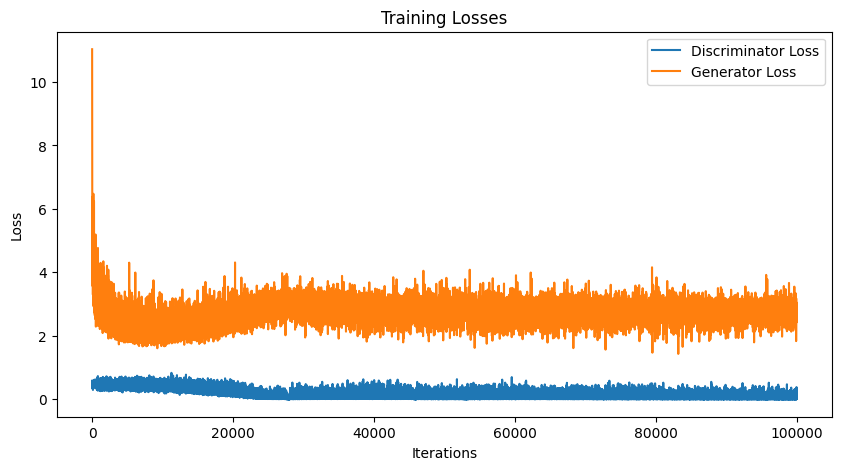

In [ ]:
#Do not run
#Plotting results
plt.figure(figsize=(10, 5))
plt.title("Training Losses")
plt.plot(d_cond_loss_arr, label='Discriminator Loss')
plt.plot(g_cond_loss_arr, label='Generator Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#Do not run
#Saving loss
d_cond_loss_arr = np.array(d_cond_loss_arr)
g_cond_loss_arr = np.array(g_cond_loss_arr)

In [ ]:
#Do not run

np.save('d_cond_loss_arr.npy', d_cond_loss_arr)
np.save('g_cond_loss_arr.npy', g_cond_loss_arr)

In [ ]:
#Run this cell
# Assuming the model was saved with GPU tensors, you might need to map tensors to CPU if you're loading on a machine without GPU
#Loading in models with appropriate weights. Change file path to match where model is saved.
MODEL_SAVE_PATH = "/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/model_checkpoints"
model_path = os.path.join(MODEL_SAVE_PATH, 'gen_cond_comic_final.pth')
model_path_f = os.path.join(MODEL_SAVE_PATH, 'gen_cond_face_final.pth')

gen_cond_comic.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

gen_cond_face.load_state_dict(torch.load(model_path_f, map_location=torch.device('cpu')))





<All keys matched successfully>

In [ ]:
#Run this cell
#Processing image to put into model. Change file path to image you want to animate.

import torchvision.transforms as transforms

image_path = '/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/sample_images/49361.jpg'
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)  # Convert to numpy array

# Define the transformations using Albumentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ToTensorV2()
])

# # # Apply the transformations

input_image = transform(image=image_np)['image'].unsqueeze(0)

condition_image = image_np.copy()
condition_input = transform(image=condition_image)['image'].unsqueeze(0)

In [ ]:
#Run this cell.
#Putting model in eval mode.
gen_cond_comic.eval()


Generator(
  (initial): Sequential(
    (0): Conv2d(6, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
#Run this cell
#Running model
with torch.no_grad():
    comic_image = gen_cond_comic(input_image, condition_input)


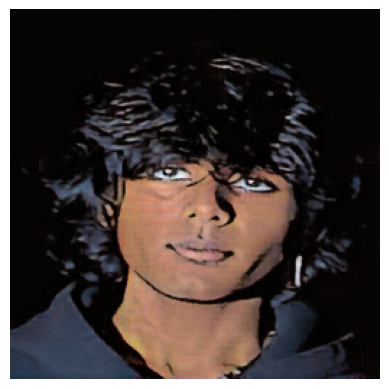

In [ ]:
#Run this cell
#Displaying comic image
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.mul(0.5).add(0.5)  # Reverse normalization
    tensor = tensor.clamp(0, 1)
    tensor = tensor.permute(1, 2, 0).numpy()  # Convert to HWC format for matplotlib
    return tensor

comic_image_np = tensor_to_image(comic_image)
plt.imshow(comic_image_np)
plt.axis('off')
plt.show()

In [ ]:
#Run this cell
#Converting comic image back to human face

image_path = '/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/sample_images/10_epochs_picture.png'
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)  # Convert to numpy array

# Define the transformations using Albumentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ToTensorV2()
])

# Apply the transformations
input_image_face = transform(image=image_np)['image'].unsqueeze(0)




condition_image = image_np.copy()
condition_input = transform(image=condition_image)['image'].unsqueeze(0)



In [ ]:
#Run this cell

#Putting model in eval mode
gen_cond_face.eval()


Generator(
  (initial): Sequential(
    (0): Conv2d(6, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
#Run this cell
#Running model to convert back to human face.
with torch.no_grad():
    face_image = gen_cond_face(input_image_face, condition_input)

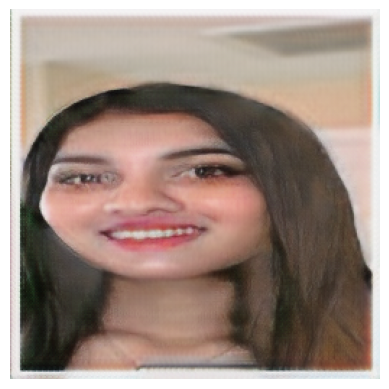

In [ ]:
#Run this cell
#plotting reconstructed face
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.mul(0.5).add(0.5)  # Reverse normalization
    tensor = tensor.clamp(0, 1)
    tensor = tensor.permute(1, 2, 0).numpy()  # Convert to HWC format for matplotlib
    return tensor

face_image_np = tensor_to_image(face_image)
plt.imshow(face_image_np)
plt.axis('off')
plt.show()

Inception Score: Mean = 1.0034716129302979, Std = 0.00013173197177245315


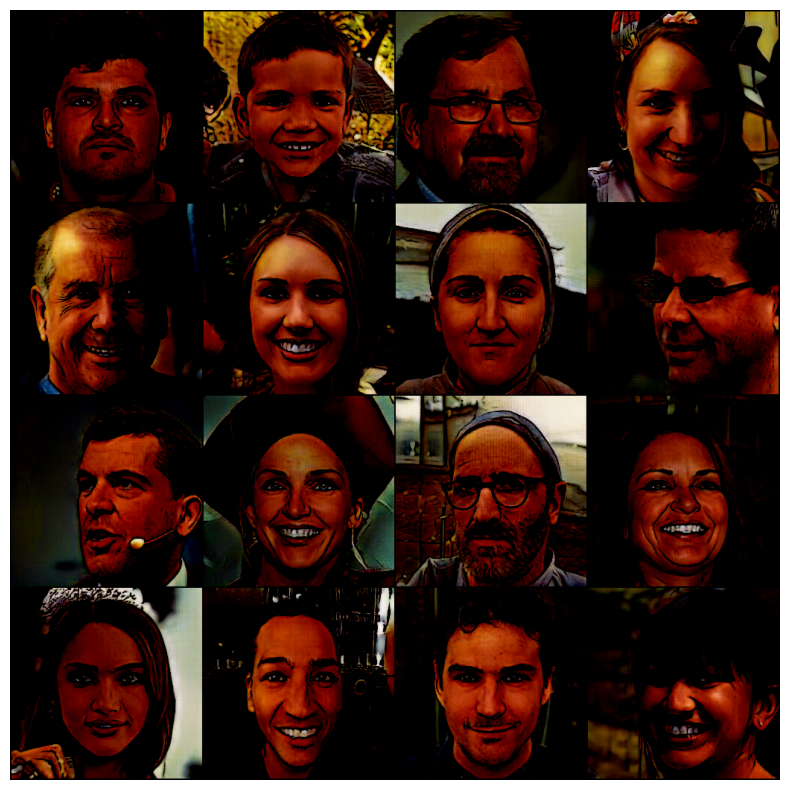

In [ ]:
#Run if you want inception score

import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load generator
gen_cond_comic.eval()

# Prepare Inception V3 model for Inception Score
inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False, aux_logits=True).to(device)
inception_model.eval()

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.endswith('.jpg')]

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        return image

# Transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ToTensorV2()
])
# Dataset and DataLoader
dataset = CustomDataset(root_dir='/content/drive/MyDrive/face2comics_v1.0.0_by_Sxela/face', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
def calculate_inception_score(preds, model, splits=10):
    scores = []
    N = preds.size(0)
    for i in range(splits):
        part = preds[i * (N // splits): (i + 1) * (N // splits), :]
        p_yx = torch.softmax(part, dim=1)
        p_y = p_yx.mean(dim=0).unsqueeze(0)
        kl_div = p_yx * (torch.log(p_yx) - torch.log(p_y))
        kl_div = kl_div.sum(dim=1)
        score = torch.exp(kl_div.mean()).item()
        scores.append(score)
    return np.mean(scores), np.std(scores)

# Generate images and evaluate inception score
all_generated_images = []
for images in dataloader:
    images = images.to(device)
    with torch.no_grad():
        generated_images = gen_cond_comic(images, images)  # Using the same images as input and condition
        all_generated_images.append(generated_images)

all_generated_images = torch.cat(all_generated_images, dim=0)
scores_mean, scores_std = calculate_inception_score(all_generated_images, inception_model)
print(f"Inception Score: Mean = {scores_mean}, Std = {scores_std}")

